In [1]:
# Install required packages
!pip install torch torchvision xgboost scikit-learn seaborn

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import gc
from time import time

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# 1. Data Loading and Preprocessing
# Define data transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Simple transforms for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# 2. Visualization Functions
def show_images(dataset, num_images=5):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].set_title(f'{classes[label]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [9]:
# 3. CNN Model Definition
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
# 4. Training Functions
def train_cnn(model, trainloader, testloader, epochs=30):
    """Train the CNN model with early stopping and learning rate scheduling"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                    patience=3, verbose=True)

    best_acc = 0.0
    patience = 5
    no_improve = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, "
              f"Accuracy: {accuracy:.2f}%")

        # Learning rate scheduling
        scheduler.step(accuracy)

        # Early stopping
        if accuracy > best_acc:
            best_acc = accuracy
            no_improve = 0
            # Save best model
            torch.save(model.state_dict(), 'best_cnn_model.pth')
        else:
            no_improve += 1
            if no_improve == patience:
                print("Early stopping triggered")
                break

    return best_acc

Displaying sample images from the dataset:


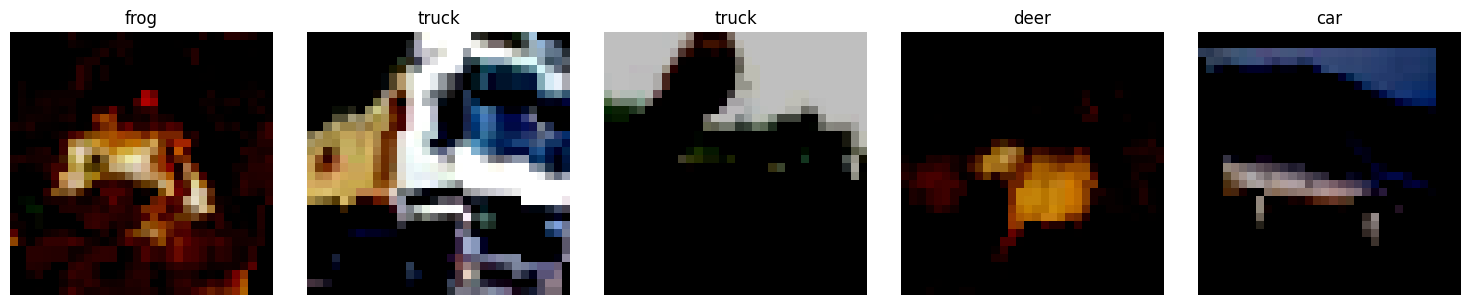


Preparing data for traditional ML models...
Applying PCA...
Explained variance ratio: 0.9010

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 40.23%
Training time: 4.27 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.45      0.48      0.46      1000
         car       0.46      0.51      0.48      1000
        bird       0.30      0.27      0.28      1000
         cat       0.31      0.28      0.29      1000
        deer       0.36      0.29      0.32      1000
         dog       0.35      0.33      0.34      1000
        frog       0.40      0.49      0.44      1000
       horse       0.44      0.42      0.43      1000
        ship       0.46      0.51      0.49      1000
       truck       0.44      0.46      0.45      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



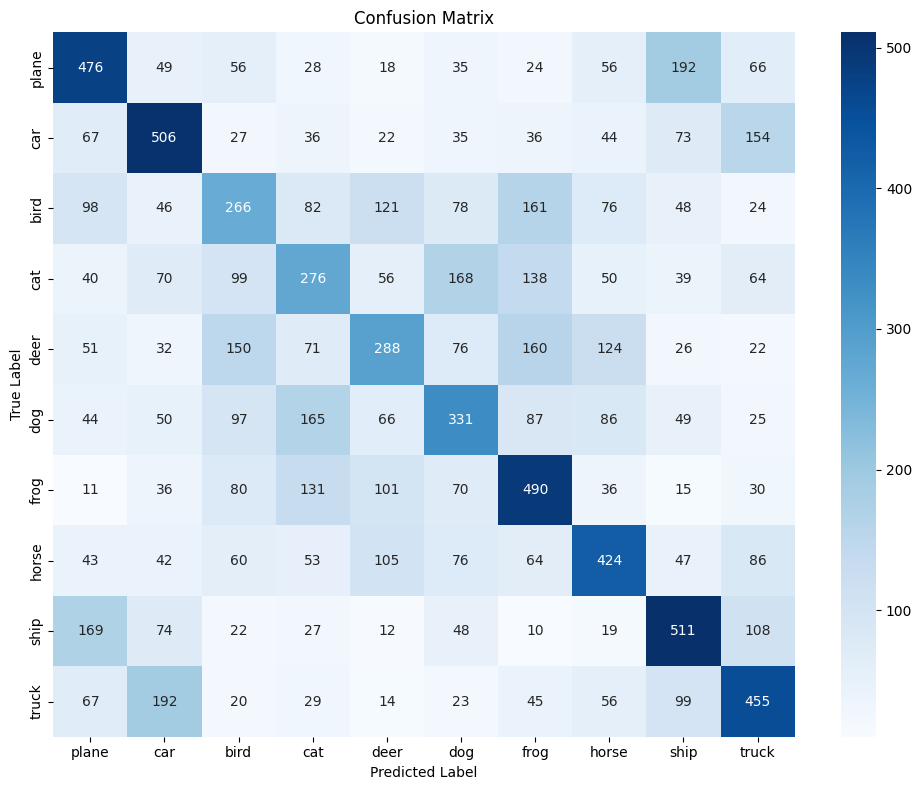


Training SVM...
SVM Results:
Accuracy: 53.96%
Training time: 378.15 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.60      0.61      0.61      1000
         car       0.66      0.65      0.65      1000
        bird       0.42      0.41      0.42      1000
         cat       0.38      0.38      0.38      1000
        deer       0.46      0.43      0.44      1000
         dog       0.49      0.43      0.46      1000
        frog       0.53      0.64      0.58      1000
       horse       0.63      0.56      0.59      1000
        ship       0.64      0.68      0.66      1000
       truck       0.58      0.61      0.59      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



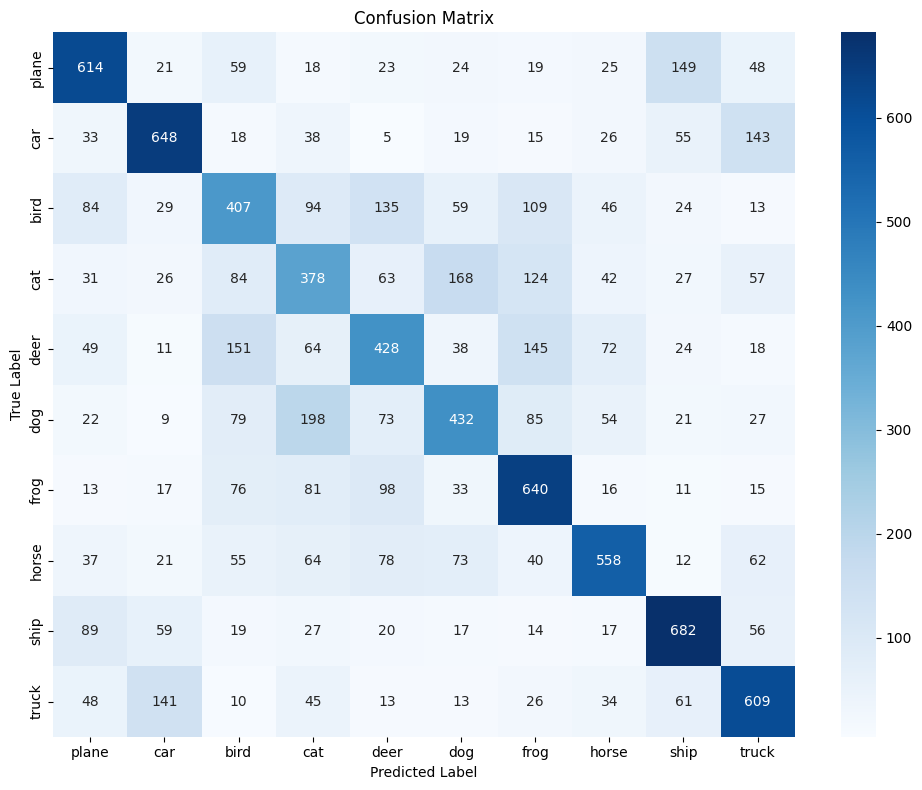


Training KNN...
KNN Results:
Accuracy: 38.08%
Training time: 0.02 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.39      0.58      0.47      1000
         car       0.61      0.30      0.41      1000
        bird       0.25      0.46      0.33      1000
         cat       0.30      0.19      0.24      1000
        deer       0.27      0.46      0.34      1000
         dog       0.45      0.24      0.31      1000
        frog       0.35      0.41      0.38      1000
       horse       0.64      0.28      0.39      1000
        ship       0.47      0.62      0.54      1000
       truck       0.71      0.24      0.36      1000

    accuracy                           0.38     10000
   macro avg       0.44      0.38      0.38     10000
weighted avg       0.44      0.38      0.38     10000



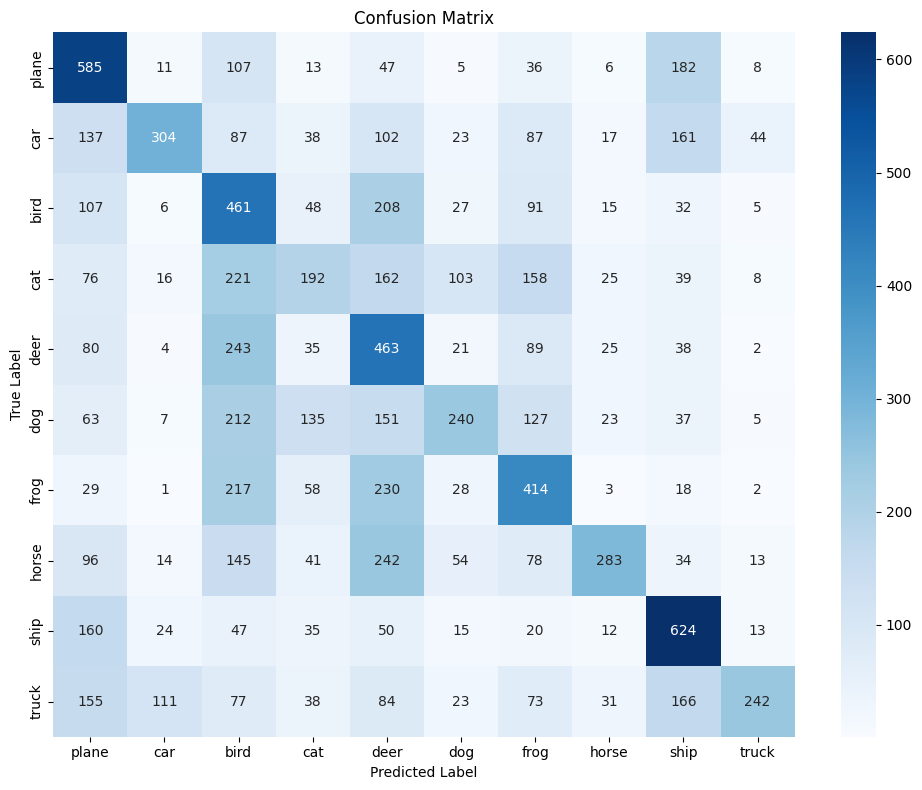


Training Naive Bayes...
Naive Bayes Results:
Accuracy: 33.77%
Training time: 0.12 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.38      0.20      0.26      1000
         car       0.42      0.46      0.44      1000
        bird       0.20      0.10      0.13      1000
         cat       0.29      0.21      0.24      1000
        deer       0.24      0.61      0.34      1000
         dog       0.37      0.26      0.30      1000
        frog       0.42      0.33      0.37      1000
       horse       0.45      0.35      0.39      1000
        ship       0.41      0.41      0.41      1000
       truck       0.34      0.46      0.39      1000

    accuracy                           0.34     10000
   macro avg       0.35      0.34      0.33     10000
weighted avg       0.35      0.34      0.33     10000



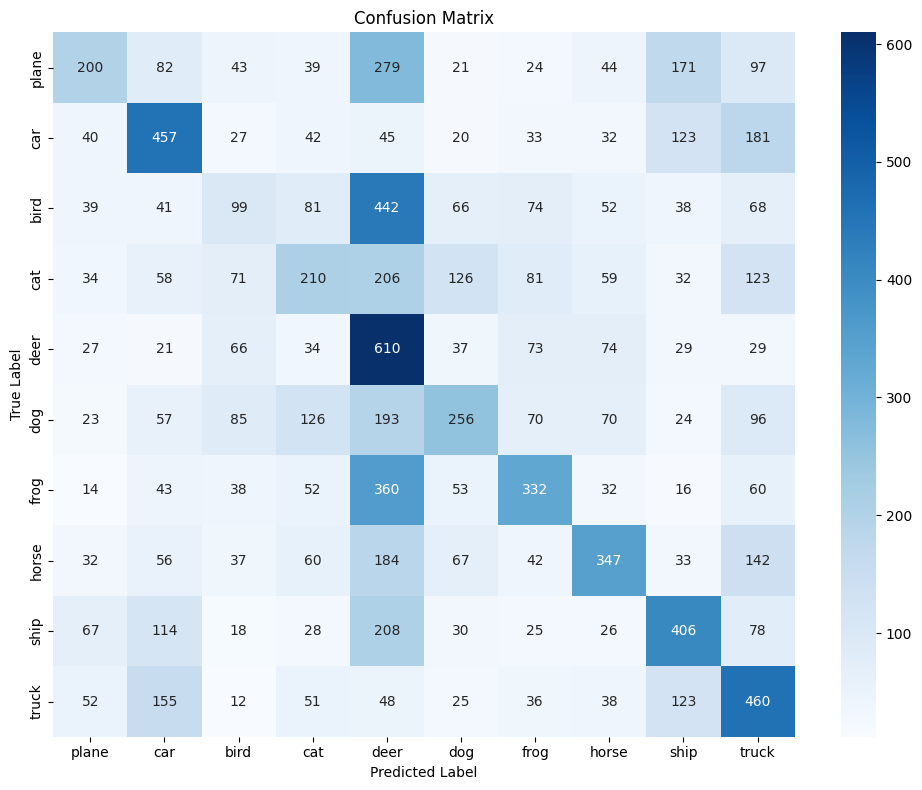


Training Random Forest...
Random Forest Results:
Accuracy: 46.16%
Training time: 113.90 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.53      0.57      0.55      1000
         car       0.52      0.59      0.55      1000
        bird       0.37      0.31      0.34      1000
         cat       0.31      0.27      0.29      1000
        deer       0.42      0.39      0.41      1000
         dog       0.38      0.36      0.37      1000
        frog       0.48      0.57      0.52      1000
       horse       0.52      0.43      0.47      1000
        ship       0.55      0.62      0.58      1000
       truck       0.47      0.50      0.48      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



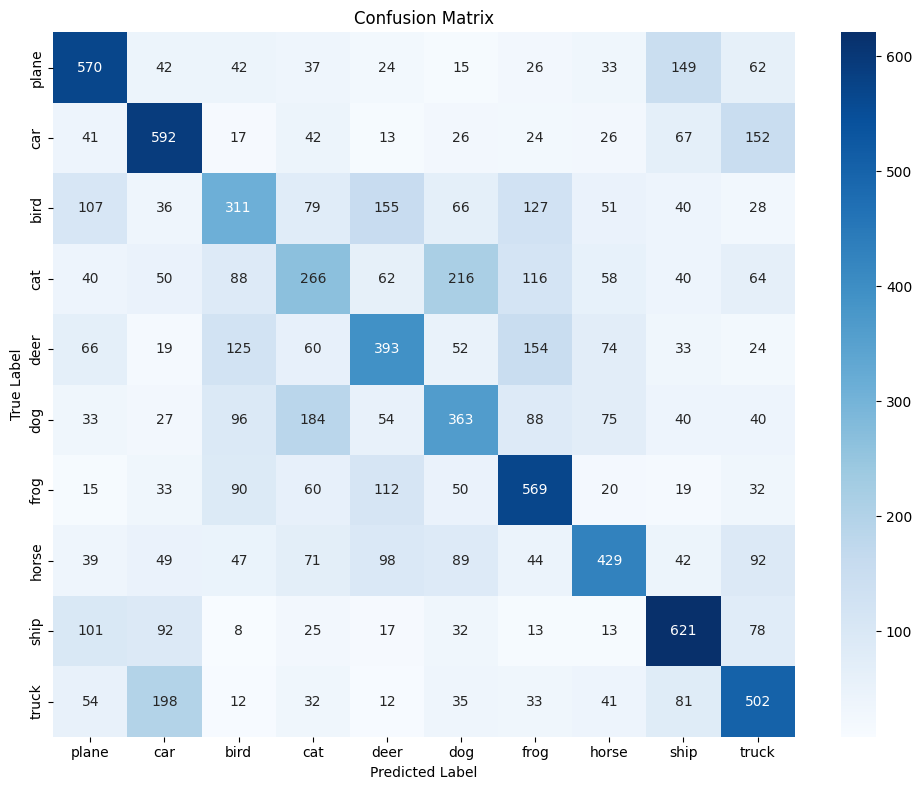


Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 50.22%
Training time: 68.85 seconds

Classification Report:
              precision    recall  f1-score   support

       plane       0.59      0.58      0.59      1000
         car       0.60      0.60      0.60      1000
        bird       0.41      0.37      0.39      1000
         cat       0.31      0.32      0.31      1000
        deer       0.46      0.42      0.44      1000
         dog       0.42      0.39      0.40      1000
        frog       0.52      0.60      0.56      1000
       horse       0.56      0.55      0.55      1000
        ship       0.59      0.64      0.62      1000
       truck       0.54      0.56      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



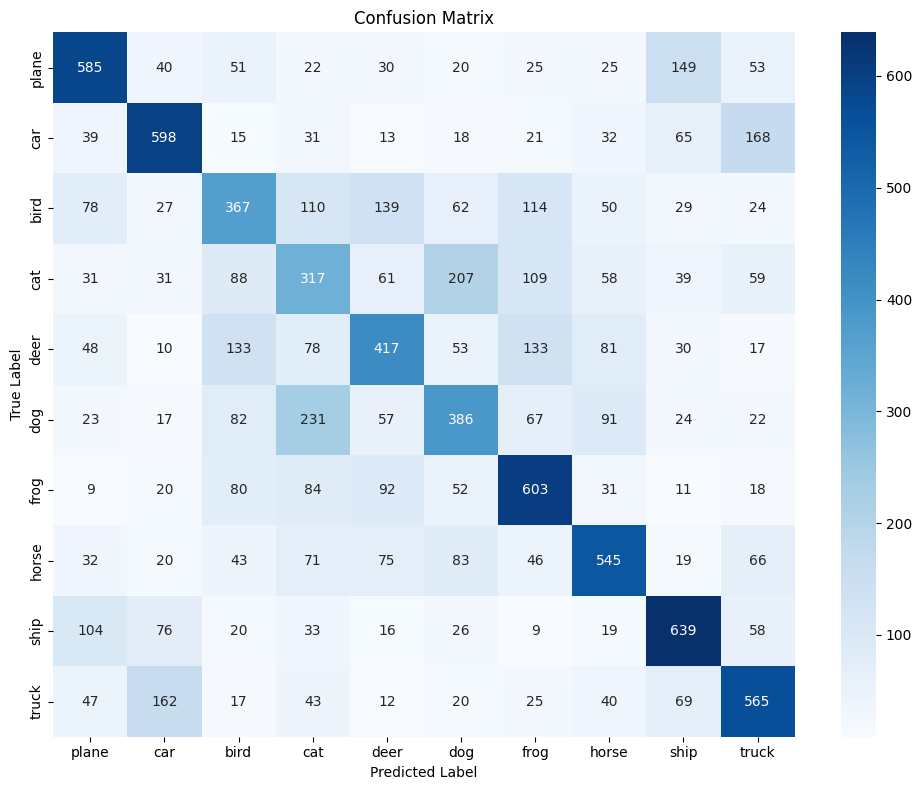


Training CNN...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 1.5211, Accuracy: 62.25%
Epoch 2, Loss: 1.1338, Accuracy: 69.24%
Epoch 3, Loss: 0.9945, Accuracy: 74.15%
Epoch 4, Loss: 0.9128, Accuracy: 75.86%
Epoch 5, Loss: 0.8547, Accuracy: 77.75%
Epoch 6, Loss: 0.8055, Accuracy: 80.06%
Epoch 7, Loss: 0.7726, Accuracy: 79.85%
Epoch 8, Loss: 0.7421, Accuracy: 82.19%
Epoch 9, Loss: 0.7150, Accuracy: 82.77%
Epoch 10, Loss: 0.6895, Accuracy: 82.77%
Epoch 11, Loss: 0.6741, Accuracy: 82.97%
Epoch 12, Loss: 0.6487, Accuracy: 84.10%
Epoch 13, Loss: 0.6221, Accuracy: 83.99%
Epoch 14, Loss: 0.6091, Accuracy: 83.84%
Epoch 15, Loss: 0.5884, Accuracy: 85.00%
Epoch 16, Loss: 0.5836, Accuracy: 85.03%
Epoch 17, Loss: 0.5679, Accuracy: 85.89%
Epoch 18, Loss: 0.5545, Accuracy: 86.23%
Epoch 19, Loss: 0.5437, Accuracy: 85.72%
Epoch 20, Loss: 0.5279, Accuracy: 86.51%
Epoch 21, Loss: 0.5176, Accuracy: 86.78%
Epoch 22, Loss: 0.5105, Accuracy: 87.07%
Epoch 23, Loss: 0.4907, Accuracy: 87.51%
Epoch 24, Loss: 0.4844, Accuracy: 87.61%
Epoch 25, Loss: 0.4775, A

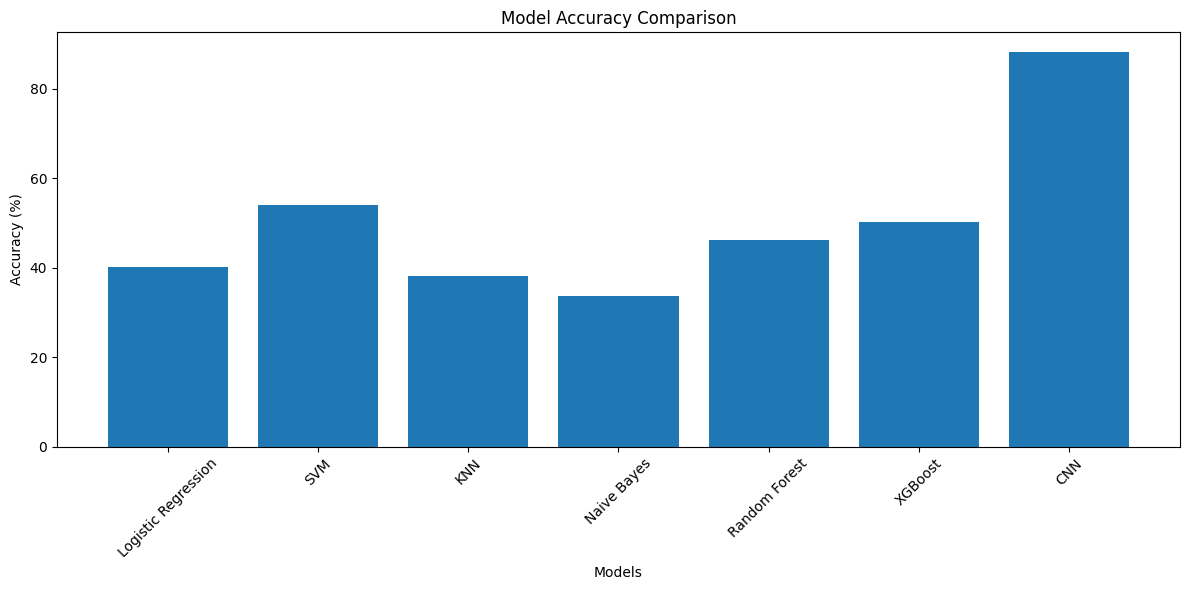

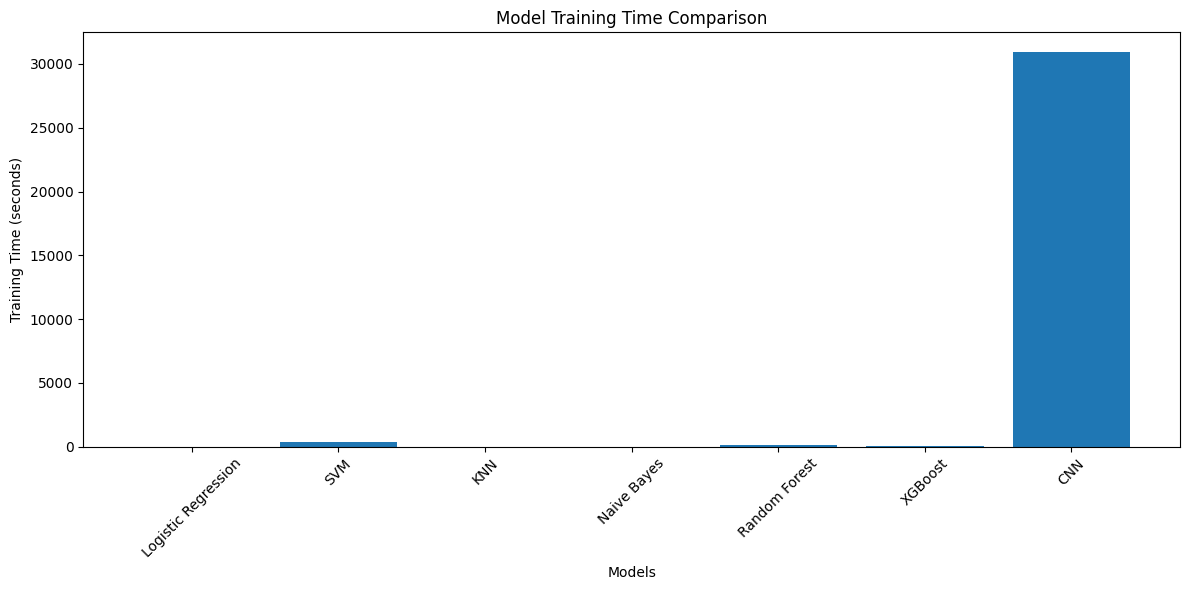


Final Results Summary:
Logistic Regression:
  Accuracy: 40.23%
  Training Time: 4.27 seconds
SVM:
  Accuracy: 53.96%
  Training Time: 378.15 seconds
KNN:
  Accuracy: 38.08%
  Training Time: 0.02 seconds
Naive Bayes:
  Accuracy: 33.77%
  Training Time: 0.12 seconds
Random Forest:
  Accuracy: 46.16%
  Training Time: 113.90 seconds
XGBoost:
  Accuracy: 50.22%
  Training Time: 68.85 seconds
CNN:
  Accuracy: 88.20%
  Training Time: 30930.87 seconds

Best Model: CNN with 88.20% accuracy


In [11]:
# 5. Main Execution
if __name__ == "__main__":
    # Show sample images
    print("Displaying sample images from the dataset:")
    show_images(trainset)

    # Prepare data for traditional ML models
    print("\nPreparing data for traditional ML models...")
    X_train = trainset.data.reshape(trainset.data.shape[0], -1) / 255.0
    X_test = testset.data.reshape(testset.data.shape[0], -1) / 255.0
    y_train = np.array(trainset.targets)
    y_test = np.array(testset.targets)

    # Apply PCA
    print("Applying PCA...")
    pca = PCA(n_components=100)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

    # Dictionary to store results
    results = {}

    # Train and evaluate traditional ML models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'SVM': SVC(kernel='rbf', C=1),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time()
        model.fit(X_train_pca, y_train)
        train_time = time() - start_time

        # Evaluate
        y_pred = model.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy * 100,
            'training_time': train_time
        }

        print(f"{name} Results:")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Training time: {train_time:.2f} seconds")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=classes))

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, classes)

        # Clear memory
        gc.collect()

    # Train and evaluate CNN
    print("\nTraining CNN...")
    cnn_model = ImprovedCNN().to(device)
    start_time = time()
    cnn_accuracy = train_cnn(cnn_model, trainloader, testloader)
    cnn_time = time() - start_time

    results['CNN'] = {
        'accuracy': cnn_accuracy,
        'training_time': cnn_time
    }

    # Plot final comparison
    plt.figure(figsize=(12, 6))
    accuracies = [results[model]['accuracy'] for model in results]
    plt.bar(results.keys(), accuracies)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot training times
    plt.figure(figsize=(12, 6))
    times = [results[model]['training_time'] for model in results]
    plt.bar(results.keys(), times)
    plt.title('Model Training Time Comparison')
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print final summary
    print("\nFinal Results Summary:")
    for model in results:
        print(f"{model}:")
        print(f"  Accuracy: {results[model]['accuracy']:.2f}%")
        print(f"  Training Time: {results[model]['training_time']:.2f} seconds")

    # Find and save best model
    best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
    print(f"\nBest Model: {best_model[0]} with {best_model[1]['accuracy']:.2f}% accuracy")